<a href="https://colab.research.google.com/github/kickvicky/Anime-Faces-GAN/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

  3%|▎         | 10.0M/395M [00:00<00:03, 104MB/s]

100%|██████████| 395M/395M [00:03<00:00, 129MB/s]


In [ ]:
import os
DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [ ]:
print(os.listdir(DATA_DIR+'/images')[:10])

['34226_2011.jpg', '47785_2014.jpg', '21650_2008.jpg', '60076_2018.jpg', '38183_2012.jpg', '56249_2017.jpg', '14076_2006.jpg', '14172_2006.jpg', '12458_2005.jpg', '16520_2006.jpg']


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # std mean for three channells

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([T.Resize(image_size),T.CenterCrop(image_size),T.ToTensor(),T.Normalize(*stats)]))

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

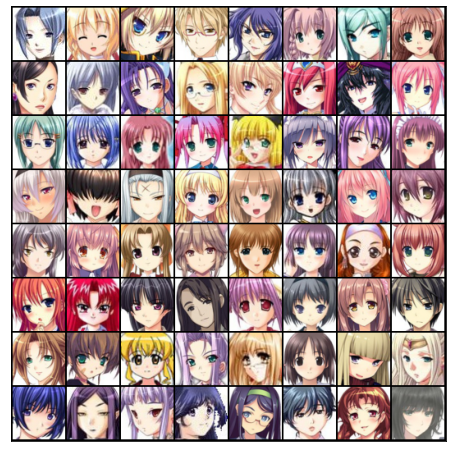

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(
    # 3 x 64 x 64
    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),
    # 64 x 32 x 32
    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),
    # 128 x 16 x 16
    nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),
    # 256 x 8 x 8
    nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),
    # 512 x 4 x 4
    nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False),
    # 1 x 1 x 1
    nn.Flatten(),
    nn.Sigmoid()
)

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
#GENERATOR

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # 128 x 1 x 1
    nn.ConvTranspose2d(latent_size,512,kernel_size=4,padding=0,stride=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # 512 x 4 x 4
    nn.ConvTranspose2d(512,256,kernel_size=4,padding=1,stride=2, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # 256 x 8 x 8
    nn.ConvTranspose2d(256,128,kernel_size=4,padding=1,stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # 128 x 16 x 16
    nn.ConvTranspose2d(128,64,kernel_size=4,padding=1,stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # 64 x 32 x 32
    nn.ConvTranspose2d(64,3,kernel_size=4,padding=1,stride=2, bias=False),
    # 3 x 64 x 64
    nn.Tanh()
)

torch.Size([128, 3, 64, 64])


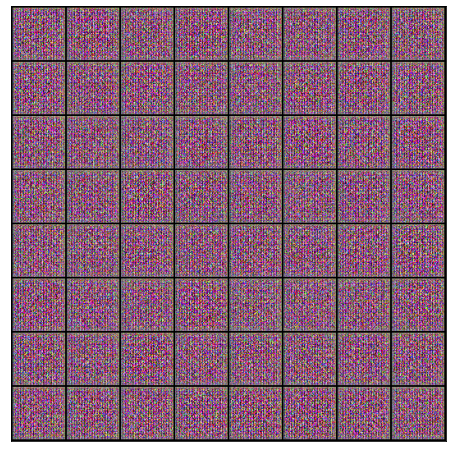

In [ ]:
xb = torch.randn(batch_size,latent_size,1,1)
out = generator(xb)
print(out.shape)
show_images(out)

In [ ]:
generator = to_device(generator, device)

In [ ]:
#DISCRIMINATOR TRAINING 

In [ ]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()

    #real images
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generating fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Passing fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
#GENERATOR TRAINING 

In [ ]:
def train_generator(opt_g):
  opt_g.zero_grad()

  #Fake images
  latent = torch.randn(batch_size,latent_size,1,1,device=device)
  fake_images = generator(latent)

  #Testing
  preds = discriminator(fake_images)
  targets = torch.ones(batch_size,1,device=device)
  loss = F.binary_cross_entropy(preds,targets)

  #Update
  loss.backward()
  opt_g.step()

  return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir,exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors,show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


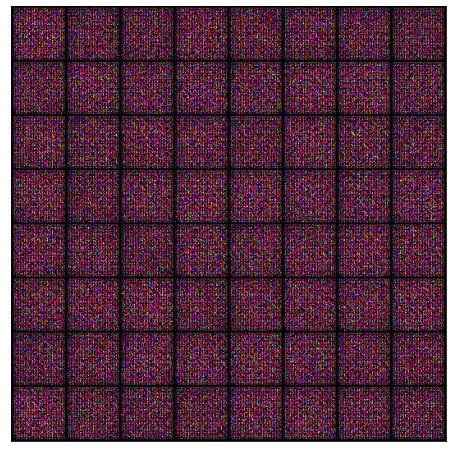

In [ ]:
save_samples(0,fixed_latent)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs,lr,start_idx=1):

  torch.cuda.empty_cache()
  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  #optimizers
  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

  for epoch in range(epochs):
    for bat,_ in tqdm(train_dl):
      #train disc
      loss_d, real_score, fake_score = train_discriminator(bat,opt_d)
      #train gen
      loss_g = train_generator(opt_g)

    # Record losses & scores
    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    #log
    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
    # Save generated img
    save_samples(epoch+start_idx, fixed_latent, show=False)
    
  return losses_g, losses_d, real_scores, fake_scores


In [ ]:
lr = 0.0002
epochs = 25

In [ ]:
history = fit(epochs,lr)


Epoch [1/25], loss_g: 7.1611, loss_d: 0.4366, real_score: 0.9767, fake_score: 0.2910
Saving generated-images-0001.png



Epoch [2/25], loss_g: 3.7208, loss_d: 0.1409, real_score: 0.9173, fake_score: 0.0413
Saving generated-images-0002.png



Epoch [3/25], loss_g: 7.9684, loss_d: 0.3516, real_score: 0.9721, fake_score: 0.2567
Saving generated-images-0003.png



Epoch [4/25], loss_g: 6.1735, loss_d: 0.3144, real_score: 0.7804, fake_score: 0.0080
Saving generated-images-0004.png



Epoch [5/25], loss_g: 4.7709, loss_d: 0.2449, real_score: 0.8403, fake_score: 0.0241
Saving generated-images-0005.png



Epoch [6/25], loss_g: 5.2271, loss_d: 0.2132, real_score: 0.9274, fake_score: 0.1116
Saving generated-images-0006.png



Epoch [7/25], loss_g: 4.0671, loss_d: 0.5465, real_score: 0.6448, fake_score: 0.0033
Saving generated-images-0007.png



Epoch [8/25], loss_g: 5.8535, loss_d: 0.1829, real_score: 0.9575, fake_score: 0.1170
Saving generated-images-0008.png



Epoch [9/25], loss_g: 3.6453, loss_d: 0.7162, real_score: 0.5985, fake_score: 0.0026
Saving generated-images-0009.png



Epoch [10/25], loss_g: 6.9325, loss_d: 0.2016, real_score: 0.9993, fake_score: 0.1601
Saving generated-images-0010.png



Epoch [11/25], loss_g: 10.2828, loss_d: 0.4224, real_score: 0.7438, fake_score: 0.0003
Saving generated-images-0011.png



Epoch [12/25], loss_g: 5.3190, loss_d: 0.1279, real_score: 0.9234, fake_score: 0.0397
Saving generated-images-0012.png



Epoch [13/25], loss_g: 2.4530, loss_d: 0.5199, real_score: 0.6704, fake_score: 0.0021
Saving generated-images-0013.png



Epoch [14/25], loss_g: 4.0994, loss_d: 0.1577, real_score: 0.9425, fake_score: 0.0811
Saving generated-images-0014.png



Epoch [15/25], loss_g: 3.8892, loss_d: 2.0566, real_score: 0.2294, fake_score: 0.0001
Saving generated-images-0015.png



Epoch [16/25], loss_g: 3.9233, loss_d: 0.1094, real_score: 0.9410, fake_score: 0.0416
Saving generated-images-0016.png



Epoch [17/25], loss_g: 4.4811, loss_d: 0.1926, real_score: 0.9008, fake_score: 0.0680
Saving generated-images-0017.png



Epoch [18/25], loss_g: 3.2240, loss_d: 0.1081, real_score: 0.9669, fake_score: 0.0664
Saving generated-images-0018.png



Epoch [19/25], loss_g: 5.1522, loss_d: 0.0813, real_score: 0.9423, fake_score: 0.0161
Saving generated-images-0019.png



Epoch [20/25], loss_g: 4.8741, loss_d: 0.1099, real_score: 0.9131, fake_score: 0.0121
Saving generated-images-0020.png



Epoch [21/25], loss_g: 4.8592, loss_d: 0.1105, real_score: 0.9666, fake_score: 0.0630
Saving generated-images-0021.png



Epoch [22/25], loss_g: 2.8204, loss_d: 0.2034, real_score: 0.8654, fake_score: 0.0385
Saving generated-images-0022.png



Epoch [23/25], loss_g: 4.9825, loss_d: 0.1482, real_score: 0.9720, fake_score: 0.1009
Saving generated-images-0023.png



Epoch [24/25], loss_g: 4.2525, loss_d: 0.1314, real_score: 0.9475, fake_score: 0.0628
Saving generated-images-0024.png



Epoch [25/25], loss_g: 3.9936, loss_d: 0.2483, real_score: 0.8899, fake_score: 0.0891
Saving generated-images-0025.png


In [ ]:
from IPython.display import Image

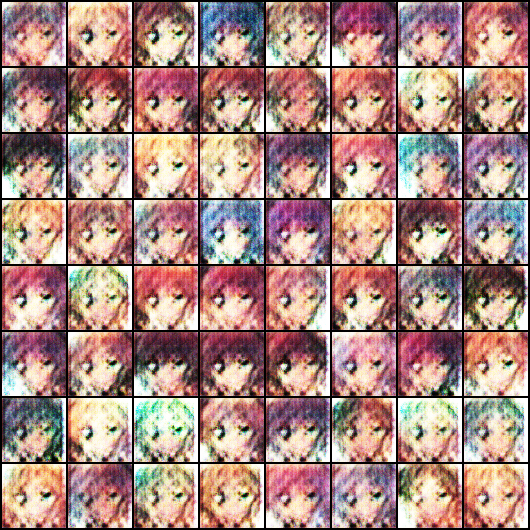

In [ ]:
Image('./generated/generated-images-0001.png')

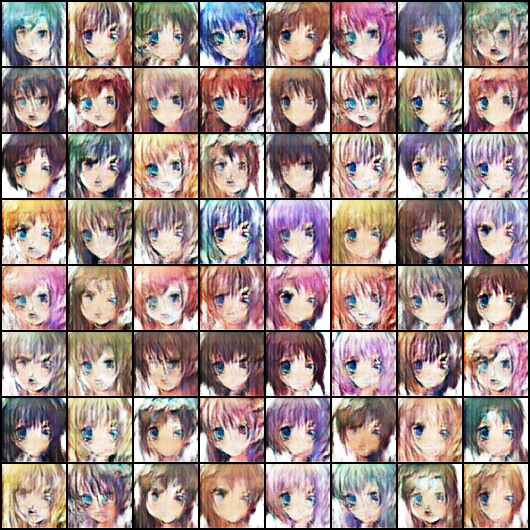

In [ ]:
Image('./generated/generated-images-0005.png')

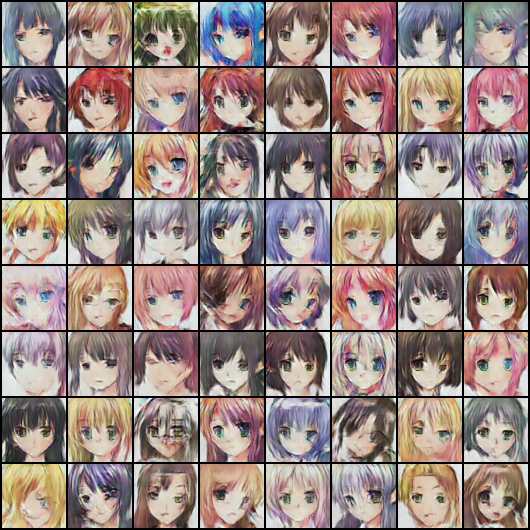

In [ ]:
Image('./generated/generated-images-0015.png')

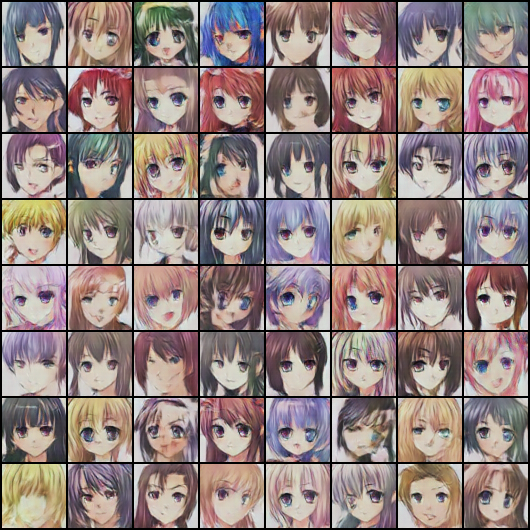

In [ ]:
Image('./generated/generated-images-0021.png')

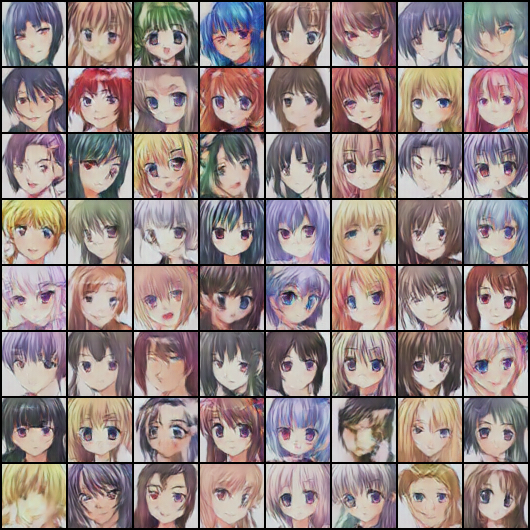

In [ ]:
Image('./generated/generated-images-0023.png')

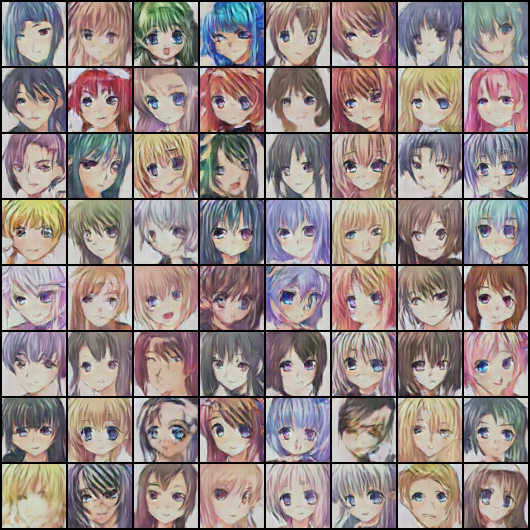

In [ ]:
Image('./generated/generated-images-0024.png')

In [ ]:
#turning into a slideshow

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'
files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()
out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [ ]:
# Saving model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')